
# Time Series Forecasting using Auto Arima

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# set font scale and style
plt.rcParams.update({'font.size': 18})

# stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 16)


,fatality_rate,med_fatal,med_injury,med_no_injury,conf_ind_head-on,conf_ind_not-head-on,c_hour,fri_fatality_rate,mon_fatality_rate,sat_fatality_rate,sun_fatality_rate,thurs_fatality_rate,tues_fatality_rate,weds_fatality_rate,year,month
date,,,,,,,,,,,,,,,,
1999-01-01,0.012911,163.0,164.0,89.0,152.0,281.0,13.511338,0.013243,0.016598,0.014843,0.011677,0.011015,0.008221,0.013807,1999,1
1999-02-01,0.018163,196.0,176.0,97.0,139.0,343.0,13.499924,0.014509,0.014981,0.022738,0.031998,0.018028,0.010420,0.015851,1999,2
1999-03-01,0.020982,219.0,250.0,122.0,149.0,469.0,13.507759,0.013768,0.017110,0.021551,0.027427,0.035515,0.022345,0.013197,1999,3
1999-04-01,0.015418,190.0,154.0,83.0,82.0,356.0,13.890340,0.011209,0.012318,0.019888,0.020989,0.013578,0.016097,0.016417,1999,4
1999-05-01,0.017953,266.0,248.0,99.0,114.0,523.0,13.851641,0.016170,0.021113,0.022777,0.025800,0.011568,0.016212,0.007870,1999,5


##  Create a test  set
We must split the dataset into training and test (out-of-sample) set. 

In [5]:
y = ts['fatality_rate']
N = len(y)

exog_variables = list(ts.drop('fatality_rate', axis=1).columns)
x_exog = ts[exog_variables]

# add seasonality variables
x_exog['yearly_seasonality'] = np.arange(N) % 365
x_exog['monthly_seasonality'] = np.arange(N) % 30.5
# x_exog['weekly_seasonality'] = np.arange(N) % 7

In [6]:
train_start, train_end = '1999-01-01','2014-12-01'
test_start, test_end = '2014-01-01', '2017-12-01'

x_train = x_exog[train_start: train_end]
y_train = y[train_start: train_end]

x_test = x_exog[test_start: test_end]
y_test = y[test_start: test_end]

## Standardization

In [7]:
# standardization
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

# pandas dataframe
x_train_df = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_df = pd.DataFrame(x_test_scaled, columns = x_test.columns)

## SARIMAX
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [8]:
# train sarimax from auto arima API
sarimax = pm.auto_arima(y_train_scaled, exogenous=x_train_df, max_p=4, max_q=4, D=1, m=12, 
                        test='adf', stepwise=True, suppress_warnings=True, 
                        error_action='ignore', seasonal=True, random_state=42, 
                        trace=True, n_fits=20
                       )
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-168.142, Time=0.19 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-185.824, Time=2.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-219.804, Time=3.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-170.142, Time=0.66 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-177.035, Time=1.18 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-222.414, Time=3.82 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-188.898, Time=3.91 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-224.734, Time=5.72 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-196.474, Time=5.59 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=10.34 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=9.45 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-219.514, Time=10.47 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-223.253, Time=10.11 sec
 ARIMA(0,0,2)(2,1,1)[12] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  192
Model:             SARIMAX(0, 0, 3)x(2, 1, [1], 12)   Log Likelihood                 139.107
Date:                              Fri, 22 Apr 2022   AIC                           -230.213
Time:                                      07:56:19   BIC                           -153.582
Sample:                                           0   HQIC                          -199.143
                                              - 192                                         
Covariance Type:                                opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
med_fatal               -0.1606      0.061     -2.618      0.009      -0.281      -0.040
med_injury              -0.1803      0.057     -3.187      0.001      -0.291      -0.069
med_no_injury           -0.0590      0.030     -1.983      0.047      -0.117      -0.001
conf_ind_head-on         0.1684      0.045      3.761      0.000       0.081       0.256
conf_ind_not-head-on     0.4447      0.119      3.743      0.000       0.212       0.678
c_hour                   0.0197      0.020      1.000      0.317      -0.019       0.058
fri_fatality_rate        0.3590      0.010     35.362      0.000       0.339       0.379
mon_fatality_rate        0.2178      0.009     24.045      0.000       0.200       0.236
sat_fatality_rate        0.2538      0.012     21.793      0.000       0.231       0.277
sun_fatality_rate        0.2750      0.009     31.384      0.000       0.258       0.292
thurs_fatality_rate      0.2479      0.010     25.764      0.000       0.229       0.267
tues_fatality_rate       0.2440      0.010     24.018      0.000       0.224       0.264
weds_fatality_rate       0.2211      0.009     24.596      0.000       0.204       0.239
year                     0.0159      0.010      1.573      0.116      -0.004       0.036
month                 1.907e-08   1.24e-08      1.534      0.125   -5.29e-09    4.34e-08
yearly_seasonality       0.0159      0.010      1.574      0.116      -0.004       0.036
monthly_seasonality      0.0054      0.007      0.787      0.431      -0.008       0.019
ma.L1                   -0.2306      0.079     -2.922      0.003      -0.385      -0.076
ma.L2                   -0.2734      0.080     -3.436      0.001      -0.429      -0.117
ma.L3                    0.5118      0.078      6.540      0.000       0.358       0.665
ar.S.L12                 0.2865      0.129      2.220      0.026       0.034       0.539
ar.S.L24                -0.1533      0.108     -1.421      0.155      -0.365       0.058
ma.S.L12                -0.8695      0.170     -5.122      0.000      -1.202      -0.537
sigma2                   0.0114      0.002      6.212      0.000       0.008       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.30
Prob(Q):                              0.86   Prob(JB):                         0.19
Heteroskedasticity (H):               0.77   Skew:                             0.20
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.31e+20. Standard errors may be unst

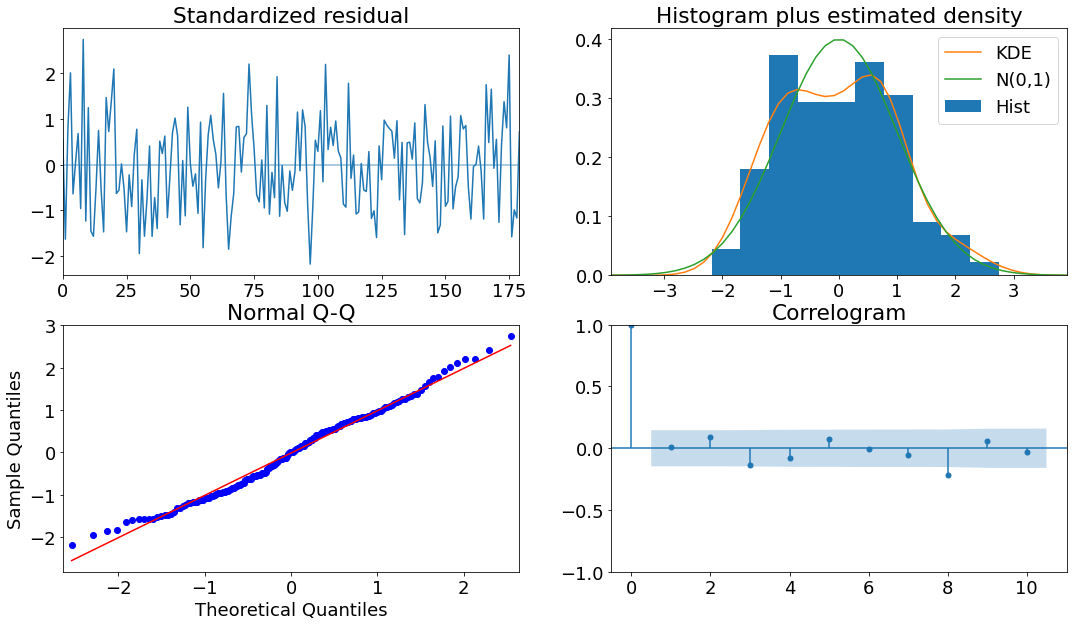

In [9]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

## Test (out-of-sample) prediction

In [10]:
y_pred, conf_int = sarimax.predict(n_periods=len(y_test), exogenous=x_test_df, return_conf_int=True)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten() # inverse transform scale

## Performance measures (error metrics)

In [11]:
fxn.error_metrics(y_test, y_pred)

{'MAE = 0.0', 'MAPE = 1.232', 'RMSE = 0.0', 'R^2 = 0.992', 'WMAPE = 1.233'}

In [15]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = scaler_y.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = scaler_y.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

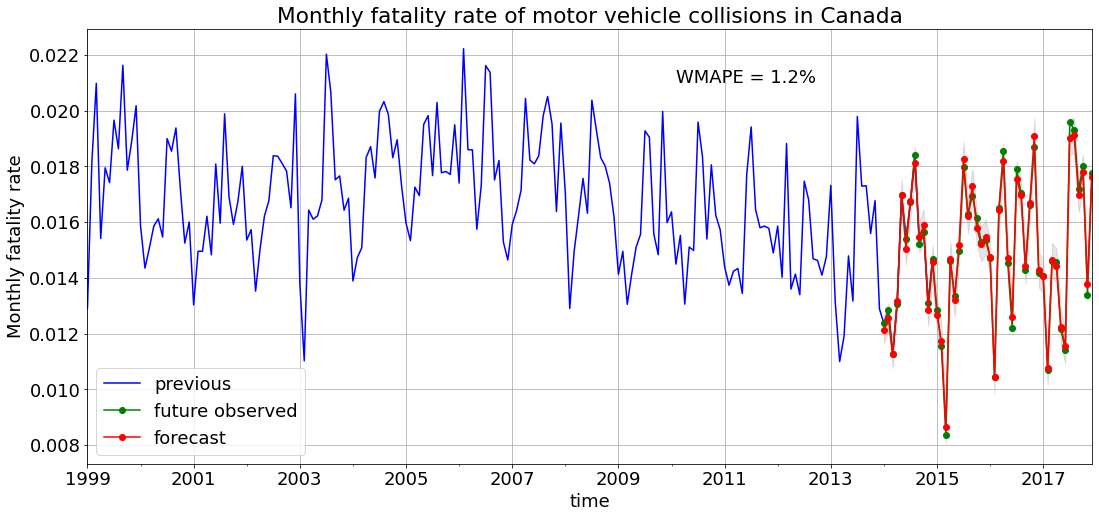

In [16]:
plt.figure(figsize = (18,8))

# y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_train.plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'r')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2010-02-01', 0.021, "WMAPE = 1.2%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly fatality rate of motor vehicle collisions in Canada')
plt.legend(loc = 'best')
plt.savefig('../images/fig_fcst.png')
plt.show()

## Model Diagnostics

## 1. Standadized residual of the test set 

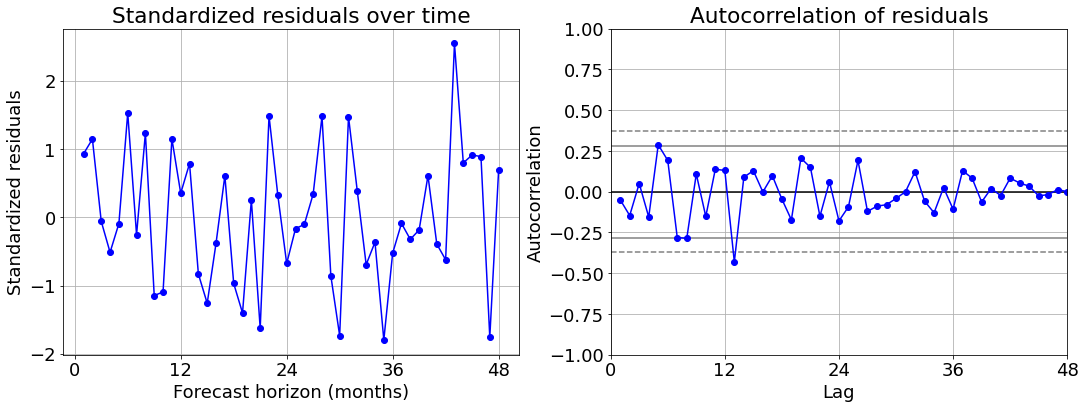

In [17]:
plt.figure(figsize = (18,6))
residual = y_test-results['y_pred']
rstandard = (residual-np.mean(residual))/np.std(residual)
ape = np.abs(residual)*100/np.abs(y_test)

plt.subplot(121)
plt.plot(range(1,len(rstandard)+1), rstandard, color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Standardized residuals')
plt.xticks(np.arange(0,len(rstandard)+1,12))
plt.title('Standardized residuals over time')

plt.subplot(122)
pd.plotting.autocorrelation_plot(pd.Series(residual), color = 'b', marker = 'o')
plt.title('Autocorrelation of residuals')
plt.xticks(np.arange(0,len(residual)+1,12))
plt.savefig('../images/figdi.png')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than 0.05 means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

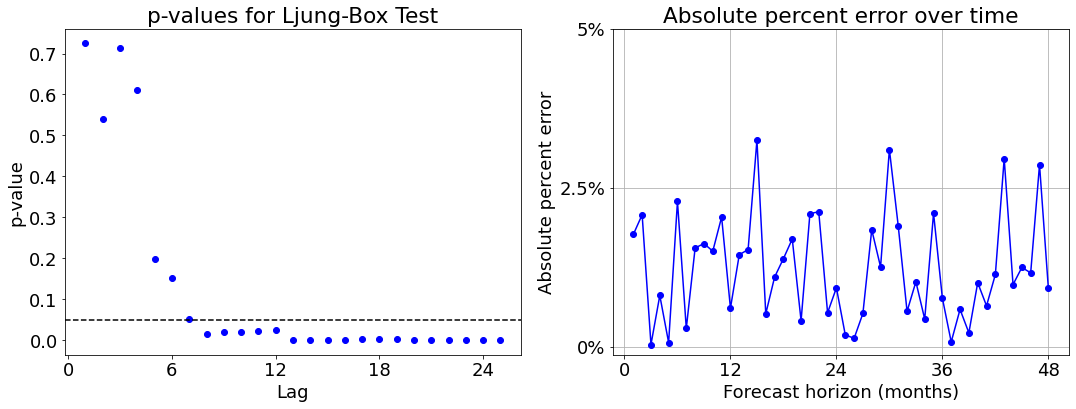

In [19]:
plt.figure(figsize = (18,6))
plt.subplot(121)
lb = acorr_ljungbox(residual, lags = 25)[1]
plt.plot(np.arange(1,len(lb)+1), lb, 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.xticks(np.arange(0,len(lb),6))
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
plt.plot(range(1,len(ape)+1), ape, color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')
label = ['0%', '2.5%', '5%']
plt.xticks(np.arange(0,len(ape)+1,12))
plt.yticks(np.arange(0,6,2.5),label)
plt.savefig('../images/figlb.png')
plt.show()